In [1]:
%matplotlib inline

# Filter warnings
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from pyod.models.pca import PCA as PCAOD
from pyod.models.cblof import CBLOF
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM as OCSVM
from sklearn.ensemble import IsolationForest
#from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
     

from sklearn.decomposition import PCA

from deepod.models.tabular import DeepSVDD, DeepIsolationForest, ICL, GOAD, RCA, RDP
from deepod.models.time_series import AnomalyTransformer, TimesNet, DeepIsolationForestTS, DCdetector, USAD
import torch

#from .unsup import UnsupervisedModels

#from .src.transfxns import TransformationPipeline

plt.rcParams.update({'font.size': 15})

# Import us custom classes
# %run -i '../src/transfxns.py'
# %run -i '../src/unsup_ml.py'
# Import ss custom class
# %run -i '../src/ss_transfxns.py'
# %run -i '../src/ss_ml.py'
# %run -i '../src/sup_ml.py'

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Instantiate the classes of unspervised learning
# transfxn = TransformationPipeline()
#model = UnsupervisedModels()
scaler = StandardScaler()

# Instantiate the class of semi-supervised learning
# transfxn_ss = TransformationPipelineSS()
# model_ss = SemiSupervised()

print(torch.cuda.is_available())

2024-01-31 15:33:56,671	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-01-31 15:33:56,790	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


True


# Define Model

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import average_precision_score


class UnsupervisedModels:
    """Unsupervised ML models."""

    def __init__(self):
        """Parameter initialization."""
        pass

    def iforest(self, X_train, n_estimators=None, random_state=None):
        """Train Isolation Forest from scikit-learn.

        Parameters
        ----------
        X_train: scaled training data
        n_estimators: number of isolation trees
        random_state: random number seed

        Returns
        -------
        Anomaly scores
        """
        model = IsolationForest(
            n_estimators=n_estimators,
            max_samples='auto',
            random_state=random_state,
        )
        model.fit(X_train)

        # predict raw anomaly score
        labels = model.predict(X_train)   # -1 for outliers and 1 for inliers
        labels = (labels.max() - labels) // 2   # 1: outliers, 0: inliers
        iforest_anomaly_scores = model.decision_function(X_train) * -1
        iforest_anomaly_scores = self.min_max_scaler(iforest_anomaly_scores)
        return iforest_anomaly_scores, labels

    def cblof(self, X_train, contamination=None, random_state=None):
        """Train CBLOF model from PYOD.

        Parameters
        ----------
        X_train: scaled training data
        contamination: percentage of anomalies in the data
        random_state: random number seed

        Returns
        -------
        Anomaly scores
        """
        model = CBLOF(contamination=contamination, random_state=random_state)
        model.fit(X_train)

        # predict raw anomaly score
        labels = model.predict(X_train)   # outlier labels (0 or 1)
        cblof_anomaly_scores = model.decision_function(X_train)
        cblof_anomaly_scores = self.min_max_scaler(cblof_anomaly_scores)
        return cblof_anomaly_scores, labels

    def ocsvm(self, X_train, kernel=None, gamma=None, nu=None):
        """Train OCSVM model from Sklearn.

        Parameters
        ----------
        X_train: scaled training data
        kernel: kernel funcs: linear, poly, rbf, sigmoid
        gamma: kernel coefficient for rbf, poly and sigmoid
        nu: regularization parameter btw [0,1]

        Returns
        -------
        Anomaly scores
        """
        model = OCSVM(kernel=kernel, gamma=gamma, nu=nu)
        model.fit(X_train)

        # predict raw anomaly score
        labels = model.predict(X_train)  # Outlier labels (-1 or 1)
        labels = (labels.max() - labels) // 2   # 1: outliers, 0: inliers
        ocsvm_anomaly_scores = model.decision_function(X_train) * -1
        ocsvm_anomaly_scores = self.min_max_scaler(ocsvm_anomaly_scores)
        return ocsvm_anomaly_scores, labels

    def cov(self, X_train, contamination=None, random_state=None):
        """Train Elliptic Envelope model from scikit-learn.

        Parameters
        ----------
        X_train: scaled training data
        contamination: percentage of anomalies in the data
        random_state: random number seed

        Returns
        -------
        Anomaly scores
        """
        model = EllipticEnvelope(
            contamination=contamination, random_state=random_state
        )
        model.fit(X_train)

        # predict raw anomaly score
        labels = model.predict(X_train)   # -1 for outliers and 1 for inliers
        labels = (labels.max() - labels) // 2   # 1: outliers, 0: inliers)
        cov_anomaly_scores = model.decision_function(X_train) * -1
        cov_anomaly_scores = self.min_max_scaler(cov_anomaly_scores)
        return cov_anomaly_scores, labels

    def pca(self, X_train, n_components=None, contamination=None):
        """Train PCA model from PYOD.

        Parameters
        ----------
        X_train: scaled training data
        contamination: percentage of anomalies in the data
        n_components: number of components to transform

        Returns
        -------
        Anomaly scores
        """
        model = PCAOD(n_components=n_components, contamination=contamination)
        model.fit(X_train)

        # predict raw anomaly score
        labels = model.predict(X_train)  # outlier labels (0 or 1)
        pca_anomaly_scores = model.decision_function(
            X_train
        )   # outlier scores
        pca_anomaly_scores = self.min_max_scaler(pca_anomaly_scores)
        return pca_anomaly_scores, labels

    def eval_metric(self, y_true, y_pred, model_nm=None):
        """Evaluation metric using the ground truth and the predicted labels.

        Parameters
        ----------
        y_pred: predicted labels
        y_true: true labels
        model_nm: name of model

        Returns
        -------
        Performance metrics
        """
        print(f'Test predictions for {str(model_nm)}')
        print('-' * 60)
        print('Accuracy:  %f' % (accuracy_score(y_true, y_pred)))
        print('AUROC: %f' % (roc_auc_score(y_true, y_pred)))
        print('AUPRC: %f' % (average_precision_score(y_true, y_pred)))
        print('Predicted classes:', np.unique(y_pred))
        print('Confusion matrix:\n', confusion_matrix(y_true, y_pred))
        print(
            'Classification report:\n', classification_report(y_true, y_pred)
        )
        print('-' * 60)

    def min_max_scaler(self, arr):
        """Min-Max normalization to rescale the anomaly scores.

        Parameters
        ----------
        arr: 1d array

        Returns
        -------
        normalized array in the range [0,100]
        """
        scaler = (arr - np.min(arr)) * 100 / (np.max(arr) - np.min(arr))
        return scaler

    def plot_dist(self, scores, color=None, title=None):
        """Plot the distribution of anomaly scores.

        Parameters
        ----------
        scores: scaled anomaly scores

        Returns
        -------
        seaborn distribution plot
        """
        # figure layout
        plt.rcParams.update({'font.size': 15})
        plt.subplots(figsize=(8, 6))

        # plot distribution with seaborn
        sns.distplot(scores, color=color)
        plt.title(label=title)
        plt.xlabel('Normalized anomaly scores')
        plt.show()
class TransformationPipeline:
    """Transformation pipeline for supervised learning."""

    def __init__(self):
        """Define parameters."""
        pass

    def num_pipeline(self, X_train, X_test):
        """Transformation pipeline of data with only numerical variables.

        Parameters
        ----------
        X_train: training feature matrix
        X_test: test feature matrix

        Returns
        -------
        Transformation pipeline and transformed data in array
        """
        # create pipeline
        num_pipeline = Pipeline(
            [
                ('std_scaler', StandardScaler()),
            ]
        )

        # original numerical feature names
        feat_nm = list(X_train.select_dtypes('number'))

        # fit transform the training set and transform the test set
        X_train_scaled = num_pipeline.fit_transform(X_train)
        X_test_scaled = num_pipeline.transform(X_test)
        return X_train_scaled, X_test_scaled, feat_nm

    def cat_pipeline(self, X_train, X_test):
        """Transformation pipeline of categorical variables.

        Parameters
        ----------
        X_train: training feature matrix
        X_test: test feature matrix

        Returns
        -------
        Transformation pipeline and transformed data in array
        """
        # instatiate class
        one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

        # fit transform the training set and transform the test set
        X_train_scaled = one_hot_encoder.fit_transform(X_train)
        X_test_scaled = one_hot_encoder.transform(X_test)

        # feature names for output features
        feat_nm = list(
            one_hot_encoder.get_feature_names_out(
                list(X_train.select_dtypes('O'))
            )
        )
        return X_train_scaled.toarray(), X_test_scaled.toarray(), feat_nm

    def preprocessing(self, X_train, X_test):
        """Transformation pipeline of data with both
        numerical and categorical variables.

        Parameters
        ----------
        X_train: training feature matrix
        X_test: test feature matrix

        Returns
        -------
        Transformed data in array
        """

        # numerical transformation pipepline
        num_train, num_test, num_col = self.num_pipeline(
            X_train.select_dtypes('number'), X_test.select_dtypes('number')
        )

        # categorical transformation pipepline
        cat_train, cat_test, cat_col = self.cat_pipeline(
            X_train.select_dtypes('O'), X_test.select_dtypes('O')
        )

        # transformed training and tes set
        X_train_scaled = np.concatenate((num_train, cat_train), axis=1)
        X_test_scaled = np.concatenate((num_test, cat_test), axis=1)

        # feature names
        feat_nm = num_col + cat_col
        return X_train_scaled, X_test_scaled, feat_nm

    def preprocessing_2(self, X_train, X_test):
        """This preprocessing uses scikit-learn ColumnTransformer class."""
        # Create pipelines
        num_pipeline = Pipeline(
            [
                ('imputer', SimpleImputer(strategy='median')),
                ('p_transf', PowerTransformer(standardize=False)),
                ('std_scaler', StandardScaler()),
            ]
        )

        cat_pipeline = Pipeline(
            [
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
            ]
        )

        cat_attribs = list(X_train.select_dtypes('O'))
        num_attribs = list(X_train.select_dtypes('number'))
        combo_pipeline = ColumnTransformer(
            [
                ('num', num_pipeline, num_attribs),
                ('cat', cat_pipeline, cat_attribs),
        
            ]
        )

        # fit transform the training set and transform the test set
        X_train_scaled = combo_pipeline.fit_transform(X_train)
        X_test_scaled = combo_pipeline.transform(X_test)
        feat_nms = list(combo_pipeline.get_feature_names_out())
        return X_train_scaled, X_test_scaled, feat_nms

    def pca_plot_labeled(self, X, labels, palette=None):
        """Dimensionality reduction of labeled data using PCA.

        Parameters
        ----------
        X: scaled data
        labels: labels of the data
        palette: color list

        Returns
        -------
        Matplotlib plot of two component PCA
        """
        # PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)

        # put in dataframe
        X_reduced_pca = pd.DataFrame(data=X_pca)
        X_reduced_pca.columns = ['PC1', 'PC2']
        X_reduced_pca['class'] = labels.reset_index(drop=True)

        # plot results
        plt.rcParams.update({'font.size': 15})
        plt.subplots(figsize=(8, 6))
        sns.scatterplot(
            x='PC1', y='PC2', data=X_reduced_pca, hue='class', palette=palette
        )

        # axis labels
        plt.xlabel('Principal component 1')
        plt.ylabel('Principal component 2')
        plt.title('Dimensionality reduction')
        plt.legend(loc='best')
        plt.savefig('../image/pca.png')
        plt.show()


    def pca_plot(self, X, label=None, palette=None):
        """Dimensionality reduction using PCA for unlabeled data.

        Parameters
        ----------
        X: scaled data
        label: class label
        palette: color list

        Returns
        -------
        Matplotlib plot of two component PCA
        """
        # PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)

        # put in dataframe
        X_reduced_pca = pd.DataFrame(data=X_pca)
        X_reduced_pca.columns = ['PC1', 'PC2']
        X_reduced_pca['class'] = label

        # plot figure
        plt.rcParams.update({'font.size': 15})
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

        sns.scatterplot(
            x='PC1', y='PC2', data=X_reduced_pca, palette=palette, ax=ax1
        )
        sns.scatterplot(
            x='PC1',
            y='PC2',
            data=X_reduced_pca,
            hue='class',
            palette=palette,
            ax=ax2,
        )

        # axes labels
        ax1.set_xlabel('Principal component 1')
        ax1.set_ylabel('Principal component 2')
        ax2.set_xlabel('Principal component 1')
        ax2.set_ylabel('Principal component 2')
        ax1.set_title('PCA before unsupervised anomaly detection')
        ax2.set_title('PCA after unsupervised anomaly detection')
        ax2.legend(loc='best')

    def pca_plot_3d(self, X, label=None, palette=None):
        # Apply PCA to reduce dimensionality to 3
        pca = PCA(n_components=3)
        X_pca = pca.fit_transform(X)

        df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
        df['Label'] = label

        # Plot the 3D graph
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Scatter plot for 'Normal' instances
        normal_indices = df[df['Label'] == 'normal'].index
        ax.scatter(df.loc[normal_indices, 'PCA1'], df.loc[normal_indices, 'PCA2'], df.loc[normal_indices, 'PCA3'], c='b', marker='o', label='normal')

        # Scatter plot for 'Attack' instances
        attack_indices = df[df['Label'] == 'attack'].index
        ax.scatter(df.loc[attack_indices, 'PCA1'], df.loc[attack_indices, 'PCA2'], df.loc[attack_indices, 'PCA3'], c='r', marker='^', label='attack')

        ax.set_xlabel('PCA1')
        ax.set_ylabel('PCA2')
        ax.set_zlabel('PCA3')
        ax.set_title('3D Scatter Plot of PCA-transformed Data')
        ax.legend()

        plt.show()
        

transfxn = TransformationPipeline()

# Preprocessing Data

In [3]:
csv_file_path = 'eps_hour.csv'

df_total = pd.read_csv(csv_file_path)
df_total.columns = ['create_time','count']
min_value = 0.2
max_value = 0.8
max_count = df_total['count'].max()
min_count = df_total['count'].min()

print(max_count)
print(min_count)

7680227
1


In [4]:
def preprocessing(df):
    df['create_time'] = pd.to_datetime(df['create_time'])
    df['hour'] = df['create_time'].dt.hour
    # Extract the minute part of the 'create_time' column
    df['minute'] = df['create_time'].dt.minute

    df['day'] = df['create_time'].dt.dayofweek

    # Assuming df is your DataFrame with a 'minute' column
    # Convert the 'minute' column to numeric (to handle any non-numeric entries)
    # df['minute'] = pd.to_numeric(df['minute'], errors='coerce')

    # # Generate a DataFrame with all minutes from 0 to 59
    # all_minutes = pd.DataFrame({'minute': range(60)})

    # # Merge the existing DataFrame with the generated DataFrame to fill missing minutes
    # df = pd.merge(all_minutes, df, on='minute', how='left')

    # Fill missing values with 0 for the 'count' column
    #df['count'].fillna(0, inplace=True)

    #df['count'] = min_value+(max_value-min_value)*(df['count']-min_count)/(max_count-min_count)
    first_index = df.index[df['minute'] == 0].min()

    data = []
    for i in range(int(len(df[first_index:])/60)):
        temp = df[60*i:(i+1)*60]['count'].values.tolist()
        temp = min_value+(max_value-min_value)*(temp-min_count)/(max_count-min_count)

        week = [0]*7
        week[df.iloc[24*i]['day']] = 1
        temp = np.concatenate((temp, week))

        hour = [0]*24
        hour[df.iloc[24*i]['hour']] = 1
        temp = np.concatenate((temp, hour))
        data.append(temp)

    return pd.DataFrame(data)
def plot_dist(scores, color=None, title=None):
        """Plot the distribution of anomaly scores.

        Parameters
        ----------
        scores: scaled anomaly scores

        Returns
        -------
        seaborn distribution plot
        """
        # figure layout
        plt.rcParams.update({'font.size': 15})
        plt.subplots(figsize=(8, 6))

        # plot distribution with seaborn
        sns.distplot(scores, color=color)
        plt.title(label=title)
        plt.xlabel('Normalized anomaly scores')
        plt.show()

# SKlearn Isolation Forest

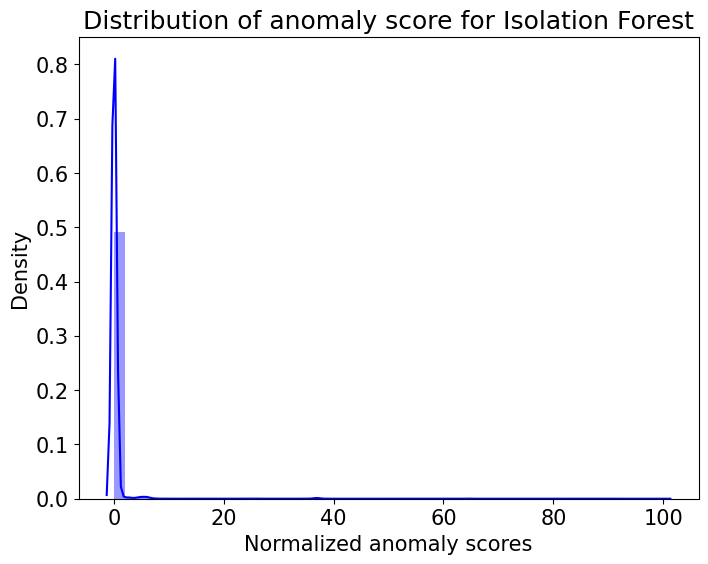

In [11]:
model = UnsupervisedModels()
df = preprocessing(df_total)
X_train = df#.drop([1895])

#scores, pred = model.iforest(X_train, n_estimators=100, random_state=100)
scores, pred = model.pca(X_train, n_components = None, contamination = 0.1)

if_df = X_train.copy()
if_df['anomaly_score'] = scores
model.plot_dist(if_df.anomaly_score, color = 'b', 
                title = 'Distribution of anomaly score for Isolation Forest')

In [7]:
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

2560
[0.21287157 0.21358062 0.21380225 0.21209871 0.21068523 0.21332851
 0.21250377 0.21199558 0.21187543 0.21181106 0.21219245 0.21259971
 0.20891872 0.20286695 0.21303368 0.21342484 0.2135978  0.21363679
 0.21201371 0.21284673 0.21433645 0.21425896 0.21311157 0.2129479
 0.21170833 0.21240971 0.21086866 0.21082179 0.20884583 0.21106038
 0.20787711 0.21365608 0.21357812 0.21380803 0.21241854 0.21357569
 0.21536595 0.20866162 0.21613726 0.2131968  0.21364929 0.21350507
 0.20990893 0.21300141 0.21298673 0.21289212 0.21442708 0.21324117
 0.20781821 0.21287571 0.2149255  0.21371764 0.21387381 0.21364499
 0.2132857  0.21352366 0.21090413 0.2118591  0.21060695 0.21225159]
100.0
2561
[0.20833186 0.21110483 0.20990658 0.21126529 0.21230229 0.20689636
 0.21424396 0.2141731  0.2136303  0.21304899 0.21274845 0.21161567
 0.2116063  0.21068476 0.21279244 0.2130536  0.21133732 0.2121073
 0.21244534 0.21294313 0.20966917 0.21576719 0.20797789 0.21471519
 0.21412849 0.21350343 0.21350406 0.21333406 0.

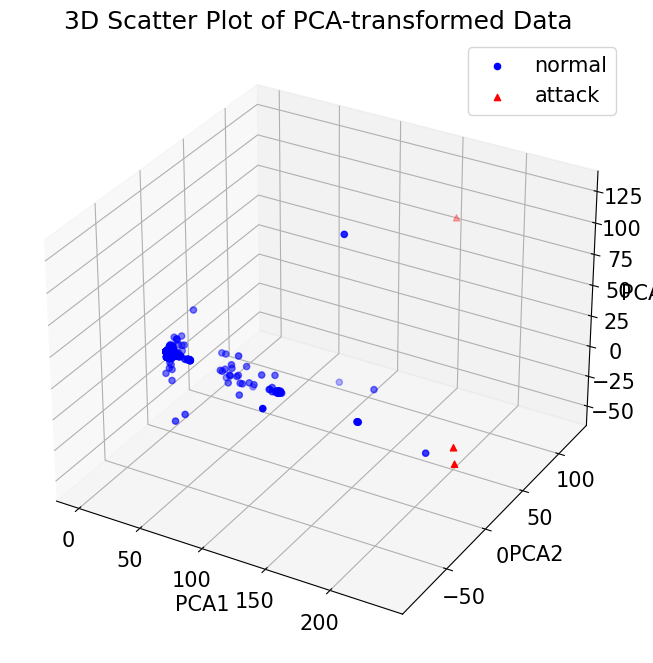

In [13]:
if_th_pred = np.where(scores >= 90, 1, 0)
if_th_pred = pd.Series(if_th_pred).map({0:'normal',1: 'attack'})

for i in range(len(if_th_pred)):
    if if_th_pred[i]=='attack':
        print(i)
        print(X_train.iloc[i].to_numpy()[:60])

        print(scores[i])
transfxn.pca_plot_3d(scaler.fit_transform(X_train), if_th_pred, palette = ['lime', 'r'])

# DeepOD

In [5]:
df = preprocessing(df_total)

#pca = PCA(n_components=10)
#df_pca = pca.fit_transform(df)
#X_train, X_test, y_train, y_test = train_test_split(df.to_numpy(), label, test_size=0.2, random_state=9527)
X_train = df.to_numpy()
#X_train = np.delete(df.to_numpy(), 1895, 0)
#print(X_train)
#device = torch.device("cpu")
#X_train = torch.tensor(df.values, dtype=torch.float32)
#print(X_scaled.shape)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf = DeepIsolationForest(device = device)
clf.fit(X_train)
print('fit complete')
scores = clf.decision_function(X_train)
scores = (scores - np.min(scores)) * 100 / (np.max(scores) - np.min(scores))
max_score = np.max(scores)
min_score = np.min(scores)

Start Training...


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.08it/s]


Start Inference on the training data...
Start Inference...


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]


fit complete
Start Inference...


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


In [12]:
from deepod.metrics import ts_metrics
from deepod.metrics import point_adjustment # execute point adjustment for time series ad
scores = clf.decision_function(X_train)

eval_metrics = ts_metrics(X_train, scores)
adj_eval_metrics = ts_metrics(X_train, point_adjustment(X_train, scores))

print(eval_metrics)

print(adj_eval_metrics)

Start Inference...


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


ValueError: continuous-multioutput format is not supported

In [8]:
df = preprocessing(df_total)
X_scaled = df
clf = DeepIsolationForest().load_model('../model/DeepIsolationForest_all.txt')
print('start predicting scores')

start predicting scores


In [6]:
sorted_score = np.argsort(scores)
print(sorted_score)
normal_index = sorted_score[:len(sorted_score)//5]
normal_data = df.iloc[normal_index]
print(normal_data)

[8480 4264 7606 ... 2559 2560 1895]
             0         1         2         3         4         5         6   \
8480   0.200026  0.200030  0.200031  0.200025  0.200026  0.200034  0.200022   
4264   0.200031  0.200033  0.200199  0.200037  0.200031  0.200034  0.200044   
7606   0.200018  0.200020  0.200030  0.200033  0.200021  0.200022  0.200020   
6765   0.200023  0.200020  0.200027  0.200030  0.200023  0.200023  0.200019   
6767   0.200020  0.200020  0.200026  0.200029  0.200027  0.200024  0.200017   
...         ...       ...       ...       ...       ...       ...       ...   
7292   0.200057  0.200046  0.200048  0.200046  0.200054  0.200045  0.200088   
10294  0.200088  0.200035  0.200026  0.200032  0.200024  0.200073  0.200023   
11302  0.200024  0.200022  0.200021  0.200024  0.200020  0.200027  0.200018   
11820  0.200048  0.200040  0.200041  0.200038  0.200038  0.200041  0.200042   
1376   0.200032  0.200032  0.200024  0.200037  0.200033  0.200036  0.200033   

             7 

In [8]:
scores

array([7.54212236, 3.12334085])

In [12]:
len([score for score in scores if score > 90])
print(len(scores))

17891


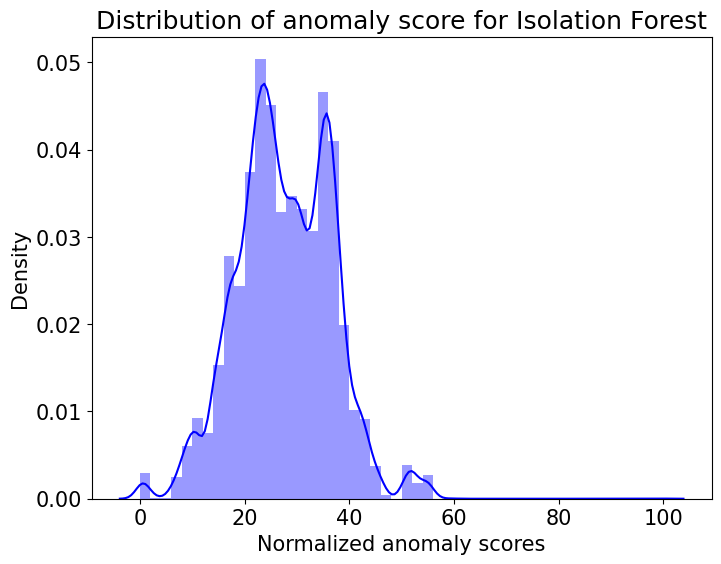

            0         1         2         3         4         5         6   \
1895  0.200014  0.207417  0.208602  0.209327  0.205158  0.204131  0.211781   

            7         8         9   ...   81   82   83   84   85   86   87  \
1895  0.206457  0.211208  0.203585  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       88   89   90  
1895  0.0  0.0  0.0  

[1 rows x 91 columns]


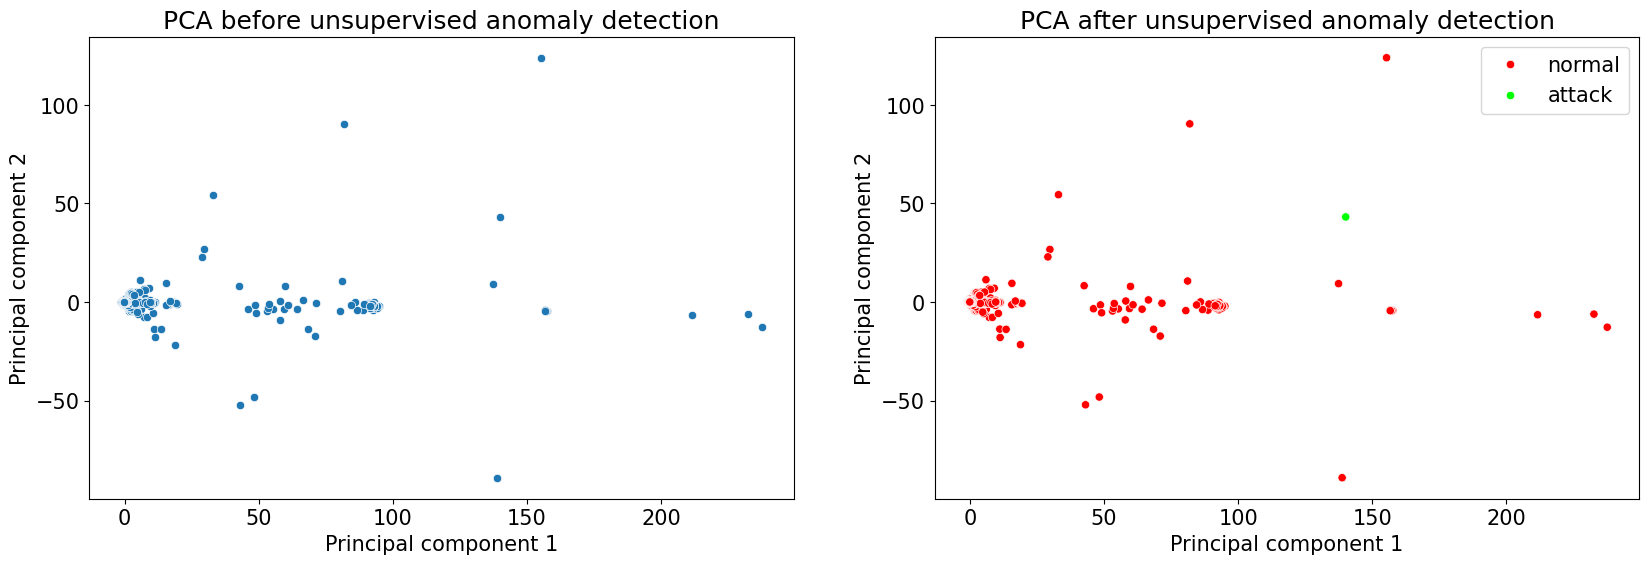

In [7]:
transfxn = TransformationPipeline()
plot_dist(scores, color = 'b', 
                title = 'Distribution of anomaly score for Isolation Forest')
# Calculate the threshold based on the 90th percentile
#threshold = pd.Series(scores).quantile(0.9)
#scores = (scores - np.min(scores)) * 100 / (np.max(scores) - np.min(scores))
threshold = 90

# Create a list to store the labels ('attack' or 'normal')
labels = ['attack' if score >= threshold else 'normal' for score in scores]
anomaly_index = []
#label = [1 if score >= threshold else 0 for score in scores]
for i in range(len(labels)):
    if labels[i]=='attack':
        anomaly_index.append(i)
anomaly_data = df.iloc[anomaly_index]

# Create a DataFrame for visualization or further analysis
result_df = pd.DataFrame({'Anomaly Score': scores, 'Label': labels})

print(anomaly_data)

# PCA plot with raw predicted labels
transfxn.pca_plot(scaler.fit_transform(X_train), labels, palette = ['r', 'lime'])

In [8]:
clf.save_model('../model/ICL_unsup_all.txt')

In [27]:
sorted_score = np.argsort(scores)
raw_index = sorted_score[len(sorted_score)//2:]
raw_index = raw_index + 1895
raw_index = np.sort(raw_index)
print(raw_index)
raw_data = preprocessing(df_total).iloc[raw_index]
print(raw_data)

[ 1895  1896  1897 ... 19757 19758 19759]


IndexError: positional indexers are out-of-bounds

# AutoEncoder

In [10]:
# sorted_score = np.argsort(scores)
# normal_index = sorted_score[:len(sorted_score)//2]
# normal_data = df.iloc[normal_index]
#print(normal_data)
X_train = normal_data.to_numpy()
#X_train = np.delete(df.to_numpy(), 1895, 0)
#print(X_train)
#device = torch.device("cpu")
#X_train = torch.tensor(df.values, dtype=torch.float32)
#print(X_scaled.shape)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf = RCA(device = device)
clf.fit(X_train)
print('fit complete')
scores = clf.decision_function(preprocessing(df_total).to_numpy())
scores = (scores - min_score) * 100 / (max_score - min_score)
#max_score = np.max(scores)
#min_score = np.min(scores)

Start Training...
ensemble size: 1
RCANet(
  (enc1): MLPnet(
    (network): Sequential(
      (0): LinearBlock(
        (linear): Linear(in_features=91, out_features=100, bias=False)
        (act_layer): LeakyReLU(negative_slope=0.01)
        (dropout_layer): Dropout(p=0.5, inplace=False)
      )
      (1): LinearBlock(
        (linear): Linear(in_features=100, out_features=50, bias=False)
        (act_layer): LeakyReLU(negative_slope=0.01)
        (dropout_layer): Dropout(p=0.5, inplace=False)
      )
      (2): LinearBlock(
        (linear): Linear(in_features=50, out_features=128, bias=False)
        (act_layer): Identity()
      )
    )
  )
  (enc2): MLPnet(
    (network): Sequential(
      (0): LinearBlock(
        (linear): Linear(in_features=91, out_features=100, bias=False)
        (act_layer): LeakyReLU(negative_slope=0.01)
        (dropout_layer): Dropout(p=0.5, inplace=False)
      )
      (1): LinearBlock(
        (linear): Linear(in_features=100, out_features=50, bias=Fals

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.83it/s]


fit complete


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.95it/s]


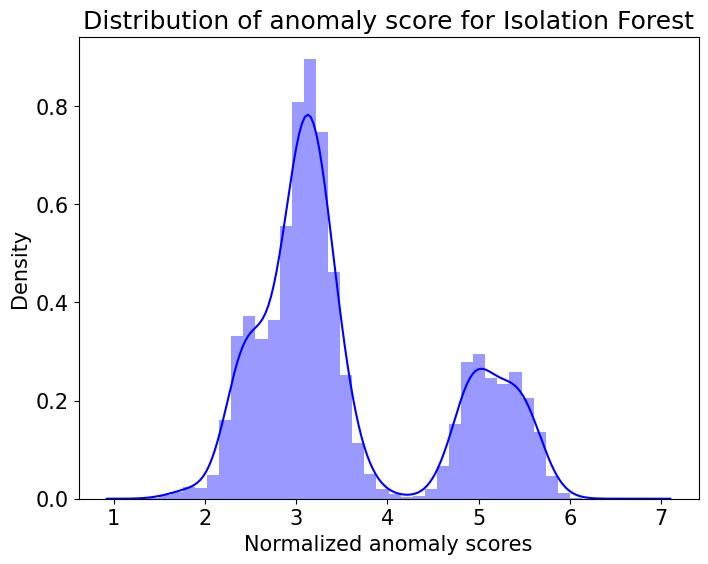

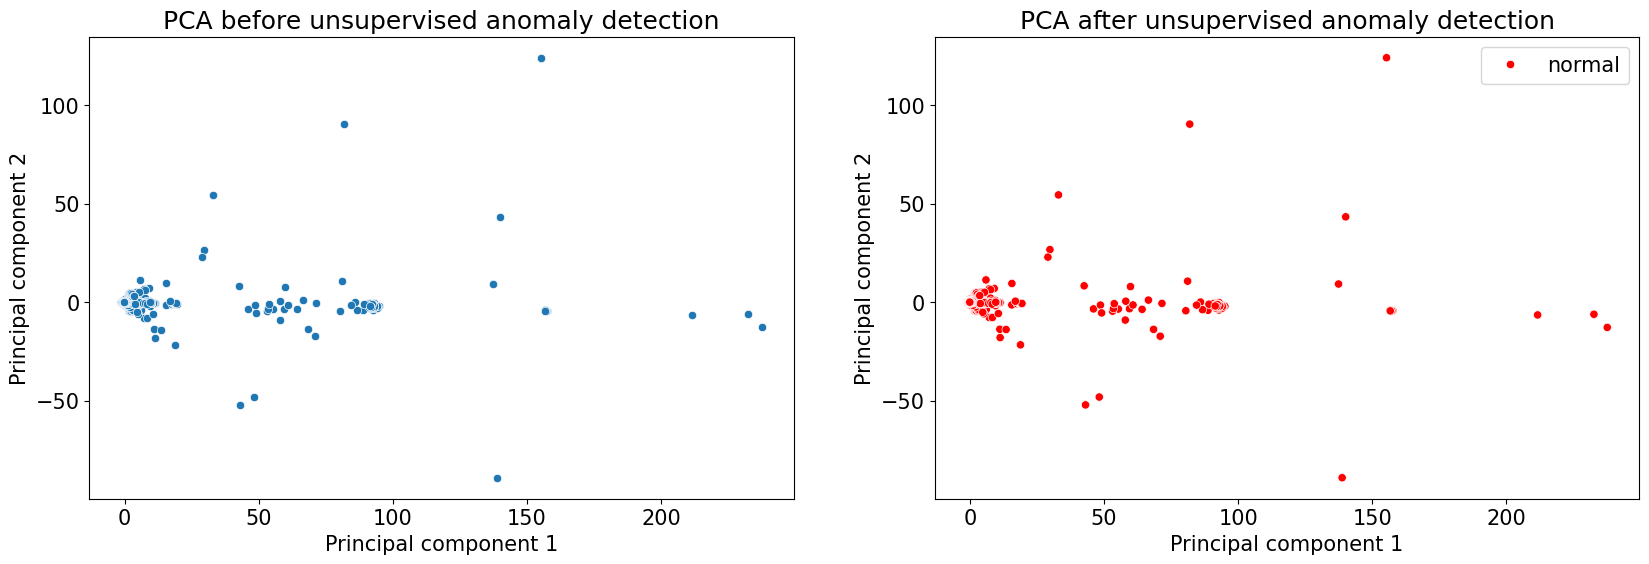

In [14]:
transfxn = TransformationPipeline()
plot_dist(scores, color = 'b', 
                title = 'Distribution of anomaly score for Isolation Forest')
# Calculate the threshold based on the 90th percentile
#threshold = pd.Series(scores).quantile(0.9)
#scores = (scores - np.min(scores)) * 100 / (np.max(scores) - np.min(scores))
threshold = 80

# Create a list to store the labels ('attack' or 'normal')
labels = ['attack' if score >= threshold else 'normal' for score in scores]
label = [1 if score >= threshold else 0 for score in scores]
# for i in range(len(labels)):
#     if labels[i]=='attack':
#         print(i)
        #print(X_train[i][43])

        #print(scores[i])

# Create a DataFrame for visualization or further analysis
result_df = pd.DataFrame({'Anomaly Score': scores, 'Label': labels})

#print(label)

# PCA plot with raw predicted labels
transfxn.pca_plot(scaler.fit_transform(preprocessing(df_total).to_numpy()), labels, palette = ['r', 'lime'])

In [59]:
from pyod.models.auto_encoder import AutoEncoder

contamination = 0.1 
epochs = 100
#print(normal_data)
X_train = normal_data.to_numpy()
X_test = preprocessing(df_total).to_numpy()
clf = AutoEncoder(epochs=100)
clf.fit(X_train)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 91)                8372      
                                                                 
 dropout_6 (Dropout)         (None, 91)                0         
                                                                 
 dense_8 (Dense)             (None, 91)                8372      
                                                                 
 dropout_7 (Dropout)         (None, 91)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                5888      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)               

101/101 [==============================] - 0s 2ms/step - loss: 0.9157 - val_loss: 2.4142
Epoch 61/100
101/101 [==============================] - 0s 2ms/step - loss: 0.9154 - val_loss: 2.4138
Epoch 62/100
101/101 [==============================] - 0s 2ms/step - loss: 0.9150 - val_loss: 2.4132
Epoch 63/100
101/101 [==============================] - 0s 2ms/step - loss: 0.9147 - val_loss: 2.4129
Epoch 64/100
101/101 [==============================] - 0s 2ms/step - loss: 0.9140 - val_loss: 2.4122
Epoch 65/100
101/101 [==============================] - 0s 2ms/step - loss: 0.9137 - val_loss: 2.4117
Epoch 66/100
101/101 [==============================] - 0s 2ms/step - loss: 0.9132 - val_loss: 2.4115
Epoch 67/100
101/101 [==============================] - 0s 2ms/step - loss: 0.9129 - val_loss: 2.4111
Epoch 68/100
101/101 [==============================] - 0s 2ms/step - loss: 0.9126 - val_loss: 2.4106
Epoch 69/100
101/101 [==============================] - 0s 2ms/step - loss: 0.9122 - val_loss: 

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[64, 32, 32, 64],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x0000022BFB2C9940>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [49]:
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores
print(y_train_scores)

[ 4.33224229  4.24782448  4.35456461 ...  6.40877166 20.04908624
  8.67180463]


In [60]:
X_test = preprocessing(df_total).to_numpy()
#X_test = np.delete(X_test, 1895, 0)

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores
print(y_test_pred)
print(y_test_scores)

560/560 [==============================] - 0s 717us/step
[1 1 1 ... 0 0 0]
[9.57388233 9.57996619 7.84426232 ... 2.50323935 2.50031519 2.50878264]


In [49]:
y_test_scores[1895]

2628.321509518825

In [53]:
len([score for score in y_test_scores if score>200])

15

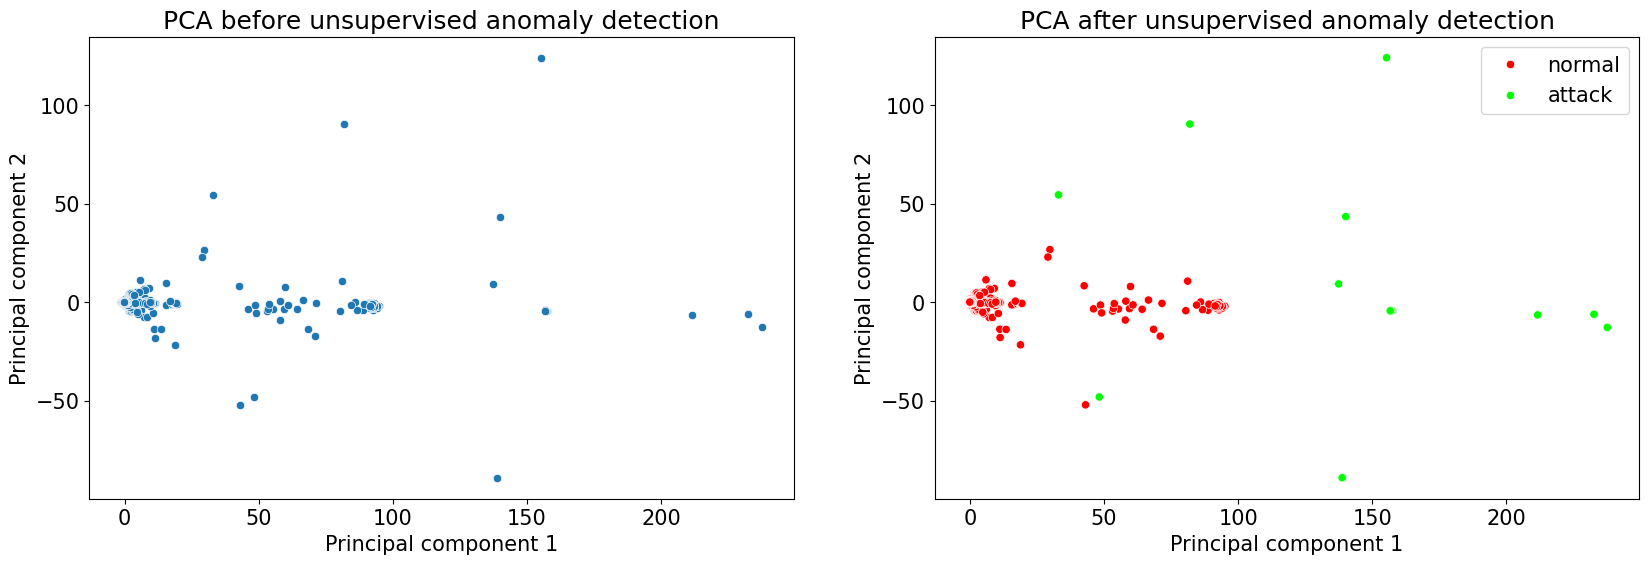

In [61]:
#plot_dist(y_test_scores, color = 'b',title = 'Distribution of anomaly score for Isolation Forest')
#y_test_scores = (y_test_scores - np.min(y_test_scores)) * 100 / (np.max(y_test_scores) - np.min(y_test_scores))
threshold = 200
#threshold = pd.Series(scores).quantile(0.9)
mapped_list = ['normal' if value == 0 else 'attack' for value in y_test_pred]
#print(mapped_list)
labels = ['attack' if score >= threshold else 'normal' for score in y_test_scores]
# for i in range(len(y_test_pred)):
#     if y_test_pred[i]==1:
#         print(i)
transfxn.pca_plot(scaler.fit_transform(X_test), labels, palette = ['r', 'lime'])

In [62]:
from joblib import dump, load

# save the model
dump(clf, '../model/AE.joblib')

['../model/AE.joblib']

# semi-sup

In [27]:
random.randint(0, 6)

3

In [36]:
fake

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,0.476610,0.480496,0.493574,0.480277,0.485563,0.491461,0.479335,0.488113,0.475766,0.482165,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.480329,0.482778,0.478735,0.487374,0.481681,0.488999,0.474550,0.490021,0.494419,0.470355,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.482062,0.490727,0.480966,0.487333,0.487097,0.495633,0.491088,0.487009,0.494283,0.499057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.480608,0.495151,0.486038,0.486946,0.480518,0.483728,0.480015,0.485757,0.501976,0.475629,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.481504,0.480127,0.473646,0.501492,0.479308,0.485456,0.484967,0.489823,0.494266,0.494564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.490352,0.494939,0.488545,0.493201,0.487756,0.485156,0.492909,0.489156,0.495889,0.500346,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.491556,0.493020,0.483870,0.474857,0.481219,0.476690,0.476163,0.496845,0.485121,0.489719,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.486753,0.491355,0.487025,0.498277,0.490784,0.487319,0.474917,0.490186,0.491541,0.481212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.480503,0.483464,0.498300,0.487369,0.505986,0.494613,0.495220,0.477961,0.485925,0.477571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
